In [1]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Weights, mart, lower_confidence_bound, wright_lower_bound,\
    intersection_mart, plot_marts_eta, union_intersection_mart
np.random.seed(123456789)

In [2]:
#to project onto polytope \mathcal{C}
#need the packages 'qpsolvers' and 'quadprog' as well as the dev version of 'pypoman'
#run these:
#pip install --upgrade --force-reinstall git+https://github.com/stephane-caron/pypoman
#pip install qpsolvers
#pip install quadprog
import qpsolvers
print(qpsolvers.available_solvers)

['cvxopt', 'quadprog']


## Wright's method vs UI-NNSM for non-random populations

In the cell below, we construct a range of $K=2$ strata, non-random populations. Each stratum is just a point-mass. We alter the global alternative (`alt_grid`), the spread between the stratum values (`delta_grid`), the sample size from each stratum (`n_grid`), and the type of bet ($\lambda_i$) used (`bets_dict`). We see whether a test based on wright's method or a test based on a UI-NNSM rejects after all $n_0 + n_1$ samples are consumed (we do not take running maxes over $t$ or deal with stratum allocation $T_k(t)$). There is no need to replicate the experiments because there is no randomness involved anywhere.  

In [8]:
alt_grid = [0.55, 0.6, 0.7]
delta_grid = [0, 0.1, 0.5]
n_grid = [5,15,30]
bets_grid = ["fixed", "agrapa", "smooth_predictable"]
bets_dict = {"fixed":Bets.lam_fixed, "agrapa":Bets.lam_agrapa, "smooth_predictable":Bets.lam_smooth_predictable}
K = 2
N = [30, 30]
results = []
for alt, delta, n_0, n_1, bet in itertools.product(alt_grid, delta_grid, n_grid, n_grid, bets_grid):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [[0, means[0]],[0, means[1]]]
    samples = [np.ones(n_0) * means[0], np.ones(n_1) * means[1]]
    wlb_reject = wright_lower_bound(
        x = samples, 
        N = N, 
        lam_func = bets_dict[bet], 
        alpha = 0.05, 
        breaks = 1000) > 0.5
    uinnsm_reject = union_intersection_mart(
        x = samples, 
        N = N, 
        eta_0 = 0.5, 
        lam_func = bets_dict[bet], 
        combine = "product", 
        log = False, 
        calX = calX)[0] > 20
    data_dict = {"alt":alt, "delta":delta, "n_0":n_0, "n_1":n_1, "bet":str(bet), "wright" : wlb_reject, "uinnsm" : uinnsm_reject}
    results.append(data_dict)
results = pd.DataFrame(results)

In [14]:
#all results
print(results.to_string())

      alt  delta  n_0  n_1                 bet  wright  uinnsm
0    0.55    0.0    5    5               fixed   False   False
1    0.55    0.0    5    5              agrapa   False   False
2    0.55    0.0    5    5  smooth_predictable   False   False
3    0.55    0.0    5   15               fixed   False   False
4    0.55    0.0    5   15              agrapa   False   False
5    0.55    0.0    5   15  smooth_predictable   False   False
6    0.55    0.0    5   30               fixed   False   False
7    0.55    0.0    5   30              agrapa   False   False
8    0.55    0.0    5   30  smooth_predictable   False   False
9    0.55    0.0   15    5               fixed   False   False
10   0.55    0.0   15    5              agrapa   False   False
11   0.55    0.0   15    5  smooth_predictable   False   False
12   0.55    0.0   15   15               fixed   False   False
13   0.55    0.0   15   15              agrapa   False   False
14   0.55    0.0   15   15  smooth_predictable   False 

In [16]:
#crosstab: the uinnsm strictly dominates wright's method in this setting
pd.crosstab(results['wright'], results['uinnsm'])

uinnsm,False,True
wright,,
False,185,37
True,0,21


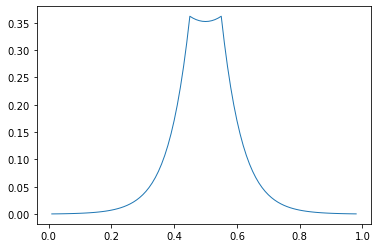

In [74]:
plot_marts_eta(
    x = samples, 
    N = N, 
    lam_func = Bets.lam_fixed, 
    combine = "fisher", 
    theta_func = Weights.theta_fixed, 
    log = False)